# ncov-19 Daily Cases 

**Data Source:** [Humanitarian Data Exchange - HDX](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases).

**Dataset:** [time_series_2019-ncov-confirmed.csv](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases/resource/4cd2eaa1-fd3e-4371-a234-a8ef2b44cc1f)


**Introduction:** A look at what measures are being taken across the globe and when. Tracking the progression over time.

**Methodology:** Descriptive and exploratory analysis 

### Summary




**Loading the dataset**

In [1]:
## libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

In [2]:
## plot settings
params = {
    'font.size' : 10.0,
    'figure.figsize': (20.0, 12.0),
    'figure.dpi' : 40
}
plt.rcParams.update(params)
plt.style.use('fivethirtyeight') #tableau-colorblind10 ggplot

In [3]:
## Load dataset from HDX
df = pd.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_19-covid-Confirmed.csv&filename=time_series_2019-ncov-Confirmed.csv")


In [4]:
## Preprocessing 
# a. reshape date columns to tidy
df = pd.melt(df, id_vars=['Country/Region', 'Lat', 'Long'], value_vars=list(df.columns)[4:], var_name="DATE_OF_CASES", value_name="NUMBER_OF_CASES")
df.columns = ['COUNTRY', 'LAT', 'LONG', 'DATE_OF_CASES', 'NUMBER_OF_CASES']

# b. define date format 
df.DATE_OF_CASES = pd.to_datetime( df.DATE_OF_CASES, format="%m/%d/%y")

# c. Clean up cases
df.COUNTRY = df.COUNTRY.str.title()

print( "Size of dataset: (rows, cols) {}".format(df.shape )  ) 
print("Most recent record was entered on {}".format(df.DATE_OF_CASES.max()))

df.head()

Size of dataset: (rows, cols) (29707, 5)
Most recent record was entered on 2020-03-22 00:00:00


,COUNTRY,LAT,LONG,DATE_OF_CASES,NUMBER_OF_CASES
0,Thailand,15.0000,101.0000,2020-01-22,2
1,Japan,36.0000,138.0000,2020-01-22,2
2,Singapore,1.2833,103.8333,2020-01-22,0
3,Nepal,28.1667,84.2500,2020-01-22,0
4,Malaysia,2.5000,112.5000,2020-01-22,0


In [5]:
%run util.ipynb

In [6]:
## cumsum by country
df_cm = df
df_cm['n'] = df_cm.groupby(by=["COUNTRY", "DATE_OF_CASES"])['NUMBER_OF_CASES'].cumsum() 
# df_cm['CUMULATIVE_CASES'] = df_cm.groupby(by=["COUNTRY", "DATE_OF_CASES"])['NUMBER_OF_CASES'].cumsum() 
df_cm = df_cm.reset_index()
df_cm['CUMULATIVE_CASES'] = df_cm.groupby(by=["COUNTRY"])['NUMBER_OF_CASES'].cumsum()
df_cm = df_cm.reset_index() 
df_cm.drop( ['level_0', 'index', 'n'], axis=1, inplace=True)
df_cm[df_cm.COUNTRY=='Thailand'].tail()

,COUNTRY,LAT,LONG,DATE_OF_CASES,NUMBER_OF_CASES,CUMULATIVE_CASES
27272,Thailand,15.0,101.0,2020-03-18,212,2431
27759,Thailand,15.0,101.0,2020-03-19,272,2703
28246,Thailand,15.0,101.0,2020-03-20,322,3025
28733,Thailand,15.0,101.0,2020-03-21,411,3436
29220,Thailand,15.0,101.0,2020-03-22,599,4035


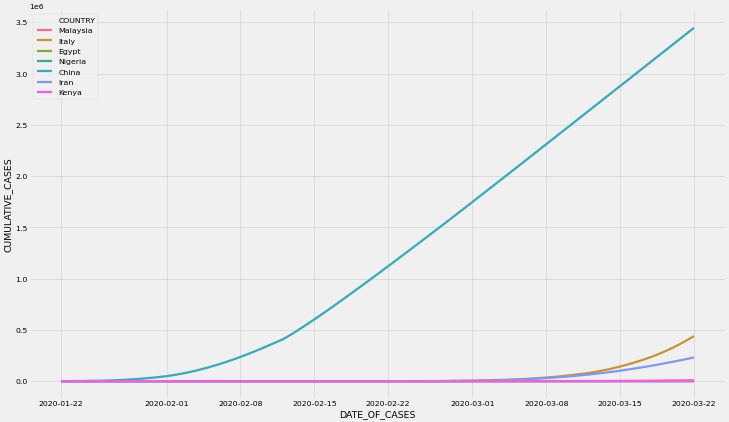

In [11]:
hyperz = [ 'Nigeria', 'Kenya', 'Egypt', 'Italy', 'Iran', 'Malaysia', 'US', 'China'] 
sns.lineplot(x='DATE_OF_CASES', y='CUMULATIVE_CASES', hue='COUNTRY', data=df_cm[df_cm.COUNTRY.isin(hyperz)])

### 1. Where are the cases?

In [16]:
df_latest = df_cm.groupby(['COUNTRY'], sort=False).max().reset_index()

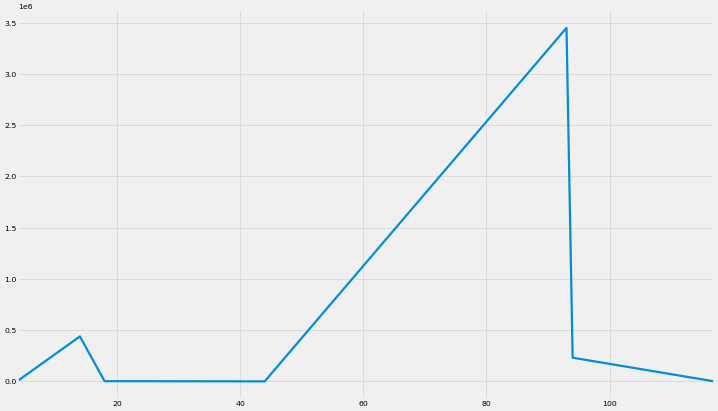

In [22]:
dtmp = df_latest[ df_latest.COUNTRY.isin( hyperz ) ]
dtmp.CUMULATIVE_CASES.plot()

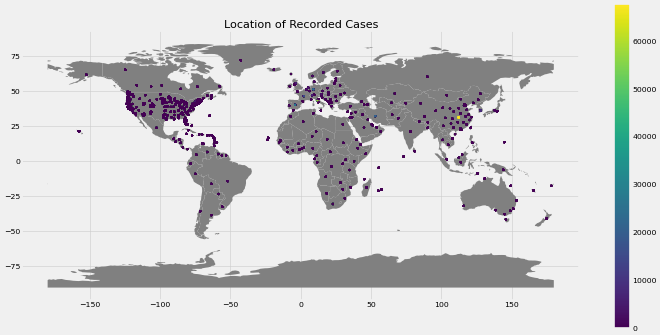

In [18]:
world = gpd.read_file( gpd.datasets.get_path('naturalearth_lowres') )

# designate coordinate system
crs = {'init': 'espc:4326'}

# zip lat and long
geom = [ Point(xy) for xy in zip(df.LONG, df.LAT) ] 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geom)
gdf.head()

fig, ax = plt.subplots( figsize=(20, 10))
world.plot(ax=ax, color='grey')

gdf.plot( column='NUMBER_OF_CASES', ax=ax, legend=True, markersize=10)
plt.title('Location of Recorded Cases')

plt.show()